In [1]:
import pandas as pd

amr_mics_1 = pd.read_csv("PRJNA292661_PATRIC_genome_amr.csv")
amr_mics_2 = pd.read_csv("PRJNA292666_PATRIC_genome_amr.csv")
frames = [amr_mics_1, amr_mics_2]

amr_mics = pd.concat(frames, axis=0, join='outer')

In [2]:
# Convert the 'Genome ID' from float to str values

# List of float 'Genome ID's
genome_ids = amr_mics.loc[:,'Genome ID'].unique().tolist()

# List of str 'Genome ID's
genome_names=[]
for i in range(3):
    gen_aux = str(float('%.8g' %genome_ids[i]))
    if len(gen_aux)==9:
        genome_names.append(gen_aux)
    elif len(gen_aux)==8:
        genome_names.append(gen_aux+'0')
    elif len(gen_aux)==7:
        genome_names.append(gen_aux+'00')
    elif len(gen_aux)==6:
        genome_names.append(gen_aux+'000')
        
# Loading genomes
genomes=[]
#for genome in id_list:
#    with open ("/home/cristian/projects/genome/PRJNA292661/PRJNA292661_genomes/"+genome+"/"+genome+".fna", "r") as file:
#        genomes.append(file.read().split(genome+"]")[1].replace("\n", "").upper())
for genome in genome_names:
    with open ("/home/cristian/projects/salmonella_enterica/genomes/"+genome+"/"+genome+".fna", "r") as file:
        genomes.append(file.read().split(genome+"]")[1].split('>')[0].replace("\n", "").upper()[:10000])

In [3]:
print(len(genomes))
print(type(genomes))
print(len(genomes[0]))

3
<class 'list'>
10000


In [4]:
# Genome sequence similarity

try:
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2
except:
    !pip install biopython
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2

# Using Clustal algorithm, for establishing the similarity among
# genomes, we'll be changing the scoring parameter
# for every match there will be a +1 point
# for every mismatch there will be a −1 point
# for every open gap there will be a −0.5 points
# for every extended gap there will be a −0.1 point

aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 0
aligner.mismatch_score = 1
aligner.open_gap_score = 0
aligner.extend_gap_score = 0

def simi_scores(genome_name_1, genome_name_2, genome_1, genome_2):
    score = aligner.score(genome_1, genome_2)
    print("{} & {} genome sequences:\t {} ({:.2f}%)\n".format(genome_name_1, genome_name_2, score,100*(score/len(genome_1))))

    
import time
import multiprocessing 

if __name__ == '__main__':
    starttime = time.time()
    processes = []
    for i in range(len(genomes)):
        if genome_names[i] != genome_names[0]:
            p = multiprocessing.Process(target=simi_scores, args=(genome_names[0], genome_names[i], genomes[0], genomes[i]))
            processes.append(p)
            p.start()
        
    for process in processes:
        process.join()
        
    print('Time {} seconds'.format(time.time() - starttime))

590.16443 & 590.16009 genome sequences:	 9255.0 (92.55%)

590.16443 & 590.12910 genome sequences:	 9258.0 (92.58%)

Time 0.5931315422058105 seconds


In [5]:
# Generating a Phylogenetic Tree

# A Phylogenetic Tree is the tree of evolutionary relationship among
# various species based on their genetic characteristics.

# UPGMA (Unweighted Pair Group Method with Arithmetic mean) algorithm

# Notice, unlike the above sequence similarity, here only the mismatch
# casesare scored using the aligner and no scoring is done for gaps and
# extended gaps.

try:
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2
except:
    !pip install biopython
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2

aligner = Align.PairwiseAligner()
aligner.mode = 'global'

# set aligner to score on mismatches
aligner.match_score = 0
aligner.mismatch_score = 1
aligner.open_gap_score = 0
aligner.extend_gap_score = 0

# code UPGMA by hand
def low_value_position(matrix):
    # cell value with min value
    minimum_value = float('inf')
    position_x = -1
    position_y = -1

    # traverse the entire matrix to find the smallest value
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if (matrix[i][j] < minimum_value):
                minimum_value = matrix[i][j]
                position_x = i
                position_y = j
    return position_x, position_y

# Combine two labels into one and erase the position with less value
# params: List of labels, positions
def join_headers(headers, a, b):
    if b < a:
        a,b = b,a

    # join labels in the first position
    headers[a] = "(" + headers[a] + "," + headers[b] + ")"

    # delete label from secnd position
    del headers[b]

# Join two columns of the matrix and save the result (average) in the first column
# Params: matrix of differences, position of the columns
def join_matrix(matrix,a ,b):
    if b < a:
        a,b = b,a

    # recalculate row for smaller index
    row = []
    for i in range(0,a):
        row.append((matrix[a][i] + matrix[b][i])/2)
    matrix[a] = row

    # recalculate entire column
    for i in range(a+1, b):
        matrix[i][a] = (matrix[i][a] + matrix[b][i])/2
        
    # get the rest of the values in row i
    for i in range(b+1, len(matrix)):
        matrix[i][a] = (matrix[i][a] + matrix[i][b])/2
        # delete the second column
        del matrix[i][b]

    # delete second row
    del matrix[b]

def upgma(matrix, headers):

    iteration = 0
    while len(headers) > 1:
#         print('\niteration: ', iteration)
#         print('total clusters: ', len(matrix))

        # locate the position in the matrix containing the lowest value
        x, y = low_value_position(matrix)

        # update the headers
        join_headers(headers, x, y)
#         print('family grouping: ', headers)

        # join two columns of the difference matrix in the position coordinates
        join_matrix(matrix,x,y)
        iteration += 1

    # final result stored in the first position
    return headers[0]

In [8]:
def difference_matrix(i, genome_i):
    row = []
    for j in range(i):
        if j < i:
            row.append(aligner.score(genomes[i], genomes[j]))
    if i==0:
        with open('diff_matrix.txt', 'w+') as f:
            f.write("%s\n" % row)
    elif i==len(genomes)-1:
        with open('diff_matrix.txt', 'a+') as f:
            f.write("%s" % row)
    else:
        with open('diff_matrix.txt', 'a+') as f:
            f.write("%s\n" % row)

import time
import multiprocessing 
    
if __name__ == '__main__':
    starttime = time.time()
    processes = []
    for i in range(len(genomes)):
        p = multiprocessing.Process(target=difference_matrix, args=(i, genomes[i]))
        processes.append(p)
        p.start()
    
    for process in processes:
        process.join()

with open("diff_matrix.txt", "r") as file:
    aux = file.read().split('\n')

diff_matrix = []
for item in aux:
    # string to list type
    diff_matrix.append(eval(item))

print(diff_matrix)   
phylogenetic_tree = upgma(diff_matrix, genome_names)
print(phylogenetic_tree)
print('That took {} seconds'.format(time.time() - starttime))

[[], [9255.0], [9258.0, 9254.0]]
(590.16443,(590.16009,590.12910))
That took 1.0383124351501465 seconds


In [6]:
diff_matrix

[[]]

In [5]:
diff_matrix = []

starttime = time.time()
for i in range(len(genomes)):
    row = []
    for j in range(i):
        if j<i:
            row.append(aligner.score(genomes[i], genomes[j]))
    diff_matrix.append(row)

print(diff_matrix)
phylogenetic_tree = upgma(diff_matrix, genome_names)
print(phylogenetic_tree)
print('That took {} seconds'.format(time.time() - starttime))

[[], [9255.0], [9258.0, 9254.0]]
(590.16443,(590.16009,590.12910))
That took 1.4720890522003174 seconds


In [6]:
diff_matrix

[[]]

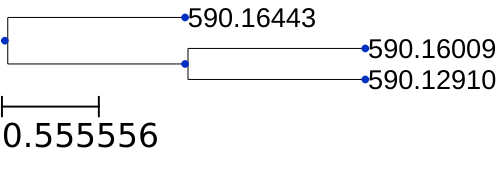

In [7]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen' # https://github.com/etetoolkit/ete/issues/296

try:
    from ete3 import Tree, TreeStyle
except:
    !pip install ete3
    from ete3 import Tree, TreeStyle
    
tree = Tree(phylogenetic_tree + ";")
# render tree image
tree.render("%%inline", w=500)

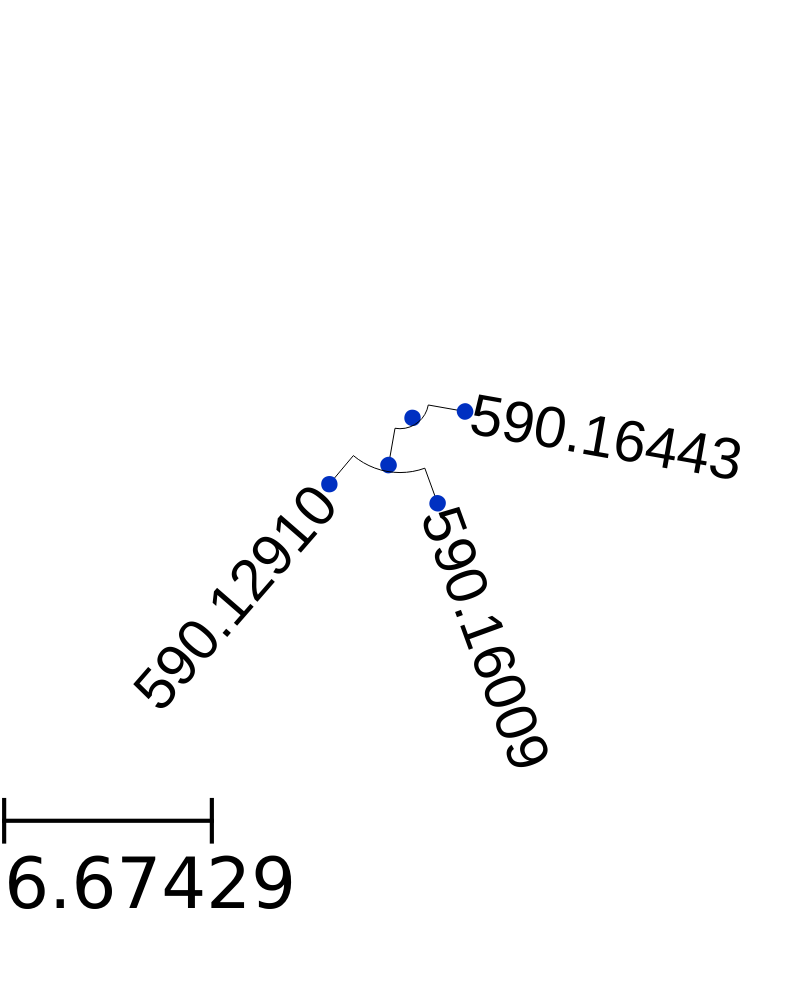

In [8]:
# show the phylogenetic family as circular tree
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = 'c'
ts.arc_start = 10 # 0 degrees = 3 o'clock
ts.arc_span = 180

tree.render("%%inline", w=800, tree_style=ts)